In [11]:
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
import shapely
import pytorch_lightning as pl
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
from pytorch_lightning.utilities import CombinedLoader
from pathlib import Path
from datetime import datetime
import segmentation_models_pytorch as smp
from functools import partial

import dl_toolbox.callbacks as callbacks
import dl_toolbox.modules as modules 
import dl_toolbox.networks as networks
import dl_toolbox.datasets as datasets
import dl_toolbox.utils as utils
import dl_toolbox.datasources as datasources
import dl_toolbox.normalizations as normalizations
import dl_toolbox.augmentations as transforms

import rasterio.windows as windows

test = True
if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename.endswith('sis.cnes.fr'):
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'
    if test:
        data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    else:
        #!bash '/home/eh/fournip/dl_toolbox/copy_data_to_node.sh'
        data_root = Path(os.environ['TMPDIR'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
normalization = partial(
    normalizations.StretchToMinmaxCommon,
    minval=[0,0,0,0],
    maxval=[1,1,1,1]
)

datasource = datasources.Digitanie(
    bands=[1,2,3],
    image_path=Path('/data/DIGITANIE_v3/Toulouse/Toulouse_EPSG32631_9.tif'),
    zone=windows.Window(0, 0, 2048, 2048),
    label_path=Path('/data/DIGITANIE_v3/Toulouse/COS9/Toulouse_9.tif'),
    nomenclature_name='main',
    normalization=normalization
)

standardize = partial(
    normalizations.ZeroAverageCommon,
    meanval=[0.123, 0.133, 0.144, 0.197]
)
    
dataset = datasets.PretiledRaster(
    data_src=datasource,
    crop_size=512,
    standardize=standardize,
    transforms=transforms.NoOp(),
    crop_step=372
)

dataloader = DataLoader(
    dataset=dataset,
    shuffle=False,
    collate_fn=utils.CustomCollate(),
    batch_size=8,
    num_workers=6
)    

In [20]:
### Building lightning module
in_channels = len(datasource.bands)
num_classes = len(datasource.nomenclature)
module = modules.Multilabel(
    network=partial(
        smp.Unet,
        encoder_name='efficientnet-b0'
    ),
    optimizer=None,
    scheduler=None,
    class_weights=[1]*num_classes,
    in_channels=in_channels,
    num_classes=num_classes
)

In [21]:
log_dir = Path('/data/outputs/split_from_csv/multilabel/2023-07-06_155303')

writer = callbacks.MergedTiffPredsWriter(
    out_path=log_dir/'digitanie',
    write_mode='pred',
    data_src=datasource,
    crop_size=dataset.crop_size,
    merge_mode='linear'
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    logger=False,
    callbacks=[
        writer,
        #callbacks.MyProgressBar(),
    ]
)

trainer.predict(
    model=module,
    dataloaders=dataloader,
    return_predictions=False,
    ckpt_path=log_dir/'checkpoints/epoch_067.ckpt'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data/outputs/split_from_csv/multilabel/2023-07-06_155303/checkpoints/epoch_067.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/split_from_csv/multilabel/2023-07-06_155303/checkpoints/epoch_067.ckpt


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


In [24]:
confs, preds = module.probas2confpreds(writer.merged.unsqueeze(dim=0))
image, label = dataset.read_crop(crop=dataset.data_src.zone)
conf_mat = callbacks.compute_conf_mat(
    label.flatten(),
    preds.flatten(),
    num_classes,
    ignore_idx=0
)

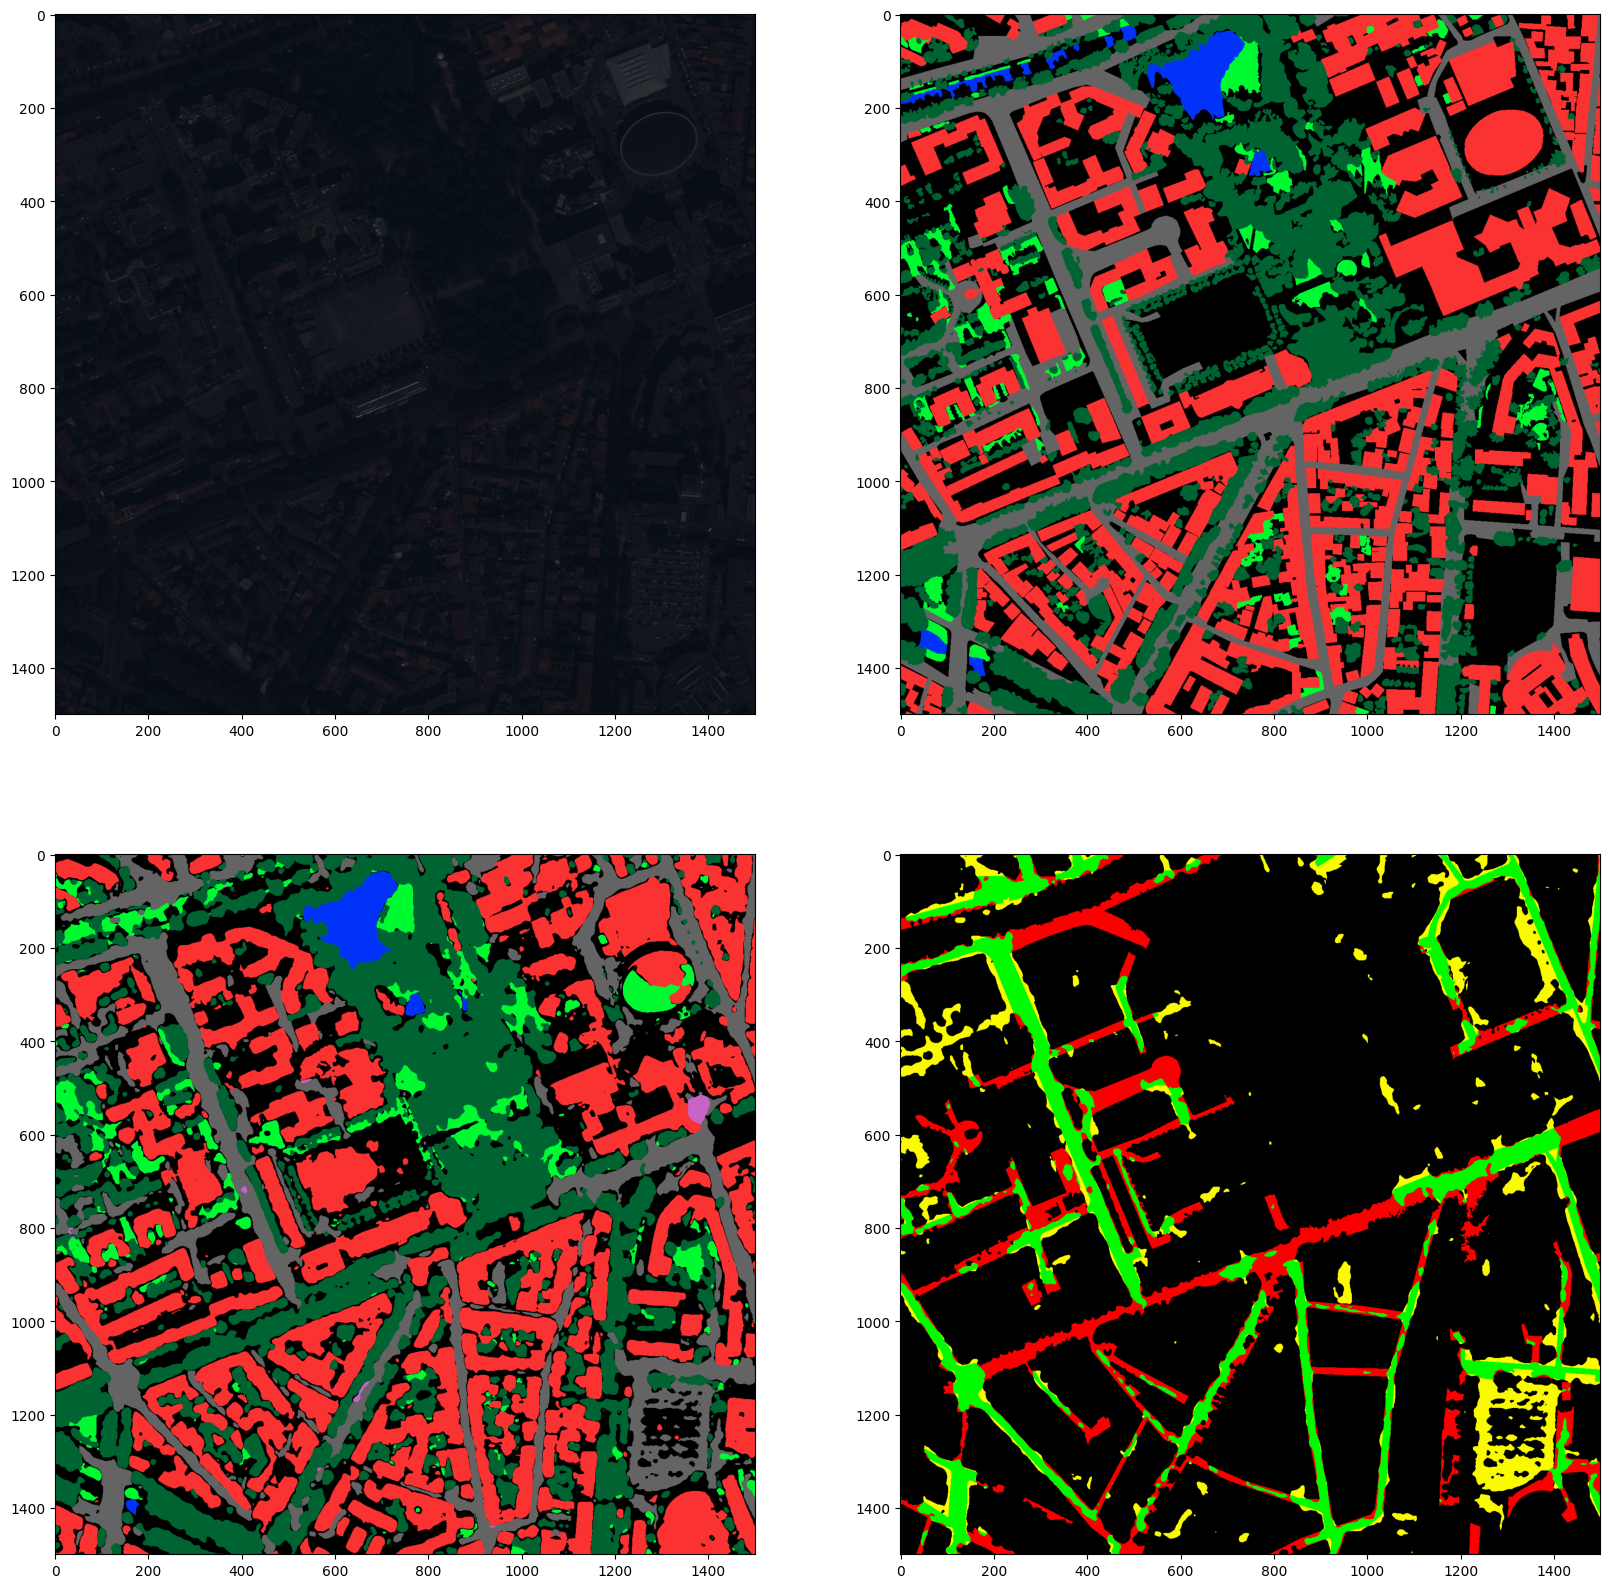

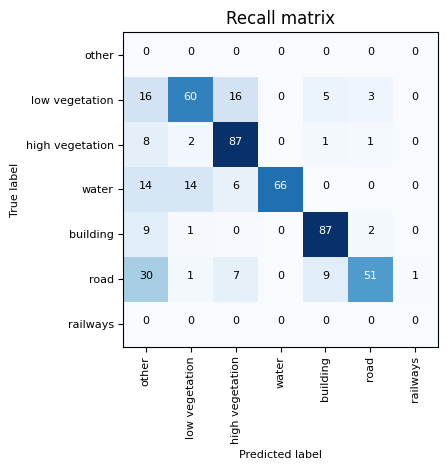

In [26]:
%matplotlib inline

pred = preds.squeeze()
imagenp = image.numpy().transpose(1,2,0)[...,:3]

overlay = np.zeros(shape=(*preds.squeeze().shape, 3), dtype=np.uint8)
label_bool = label == 5
pred_bool = pred == 5

# Correct predictions (Hits) painted with green
overlay[label_bool & pred_bool] = np.array([0, 250, 0], dtype=overlay.dtype)
# Misses painted with red
overlay[label_bool & ~pred_bool] = np.array([250, 0, 0], dtype=overlay.dtype)
# False alarm painted with yellow
overlay[~label_bool & pred_bool] = np.array([250, 250, 0], dtype=overlay.dtype)

zone = np.s_[0:1500, 0:1500, ...]

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax1.imshow(imagenp[zone])
ax2 = fig.add_subplot(222)
ax2.imshow(utils.NomencToRgb(datasource.nomenclature)(label)[zone])
ax3 = fig.add_subplot(223)
ax3.imshow(utils.NomencToRgb(datasource.nomenclature)(pred)[zone])
ax4 = fig.add_subplot(224)
ax4.imshow(overlay[zone])

fig = utils.plot_confusion_matrix(
    conf_mat,
    [label.name for label in datasource.nomenclature],
    'recall'
)